In [195]:
exp_path = block.analysis_path / 'vid_draft_pc.mp4'
export_eyetracking_video(block, [29180.65, 31422.65], [30046.9,32968.55], export_path=exp_path)

2it [00:01,  1.03it/s]


In [193]:
block.left_3d = pd.read_csv(block.analysis_path / 'left_3d_draft.csv')

In [194]:
def export_eyetracking_video_tali(block, start_ms_list, end_ms_list, xflip=True, yrotate=True, rotate_frames=True, export_path=None):
    if export_path is None:
        print('No export path supplied, use a show_eye_videos')
    le_vid = block.le_videos[0]
    re_vid = block.re_videos[0]

    if len(start_ms_list) != len(end_ms_list):
        print("Error: The number of start_ms values must be equal to the number of end_ms values.")
        return
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    output_video = cv2.VideoWriter(str(export_path),fourcc, 60.0, (640*2,480*2))
    le_cap = cv2.VideoCapture(le_vid)
    re_cap = cv2.VideoCapture(re_vid)

    if not le_cap.isOpened() or not re_cap.isOpened():
        print("Error opening video file.")
        return
    
    prev_l_frame = 0
    prev_r_frame = 0
    # fig, (ax1,ax2) = plt.subplots(1,2)
    stop_flag = False
    for i, (start_ms, end_ms) in tqdm.tqdm(enumerate(zip(start_ms_list, end_ms_list))):
        if stop_flag:
            break
        if block.left_eye_data.iloc[0].ms_axis > start_ms:
            print(f'ms_axis starts at {block.left_eye_data.iloc[0].ms_axis} but {start_ms} was requested, defaulting to earliest sample')
            start_ms = block.left_eye_data.iloc[0].ms_axis
        if block.left_eye_data.iloc[-1].ms_axis < end_ms:
            print(f'ms_axis ends at {block.left_eye_data.iloc[-1].ms_axis} but {end_ms} was requested, defaulting to last sample')
            end_ms = block.left_eye_data.iloc[-1].ms_axis

        ms_timestamps = block.left_eye_data.query('ms_axis > @start_ms and ms_axis < @end_ms')['ms_axis'].values
        
        # insert a completely white frame segment of 0.5 seconds (30 frames)
        for current_ms in ms_timestamps:
            current_le_frame = int(block.left_eye_data.query('ms_axis == @current_ms').eye_frame)
            current_re_frame = int(block.right_eye_data.query('ms_axis == @current_ms').eye_frame)
            
            # creating plot 
            tmp_df_2d = block.left_eye_data.query('ms_axis > @current_ms - 200 and ms_axis < @current_ms')
            tmp_df_3d = block.left_3d.query('timestamp > @current_ms - 200 and timestamp < @current_ms')
            c = np.arange(len(tmp_df_2d))
            ax1 = plt.scatter(tmp_df_2d['center_x'],tmp_df_2d['center_y'], c=c, cmap='Blues')
            ax2 = plt.scatter(tmp_df_3d['phi'],tmp_df_3d['theta'], c=c, cmap='Blues')
            plt.colorbar(ax1)
            fig.canvas.draw()
            # convert canvas to image
            img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            # img is rgb, convert to opencv's default bgr
            img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
            img = cv2.resize(img, (1280, 480))
            
            if prev_l_frame + 1 != current_le_frame:
                le_cap.set(cv2.CAP_PROP_POS_FRAMES, current_le_frame)
            l_ret, l_frame = le_cap.read()

            if prev_r_frame + 1 != current_re_frame:
                re_cap.set(cv2.CAP_PROP_POS_FRAMES, current_re_frame)
            r_ret, r_frame = re_cap.read()

            if not r_ret or not l_ret:
                break

            if xflip:
                l_frame = cv2.flip(l_frame, 1)
                r_frame = cv2.flip(r_frame, 1)
            
            if rotate_frames:
                if block.left_rotation_matrix is None or block.right_rotation_matrix is None:
                    raise AttributeError('At least one rotation matrix is missing... \n '
                                         'Run the rotate_frame_to_horizontal_with_interpolation for each eye video')
                else:
                    l_frame = cv2.warpAffine(l_frame, block.left_rotation_matrix, (l_frame.shape[1], l_frame.shape[0]))
                    r_frame = cv2.warpAffine(r_frame, block.right_rotation_matrix, (r_frame.shape[1], r_frame.shape[0]))
            # if you want to plot something on the frame, do it before rotation and rotate the annotated frame
            if yrotate:
                l_frame = cv2.rotate(l_frame, cv2.ROTATE_180)
                r_frame = cv2.rotate(r_frame, cv2.ROTATE_180)
                
            synchronized_frame = cv2.hconcat([r_frame, l_frame])
             
            # Add a black lower section to the frame
            black_section = np.zeros((l_frame.shape[0], l_frame.shape[1]*2, 3), dtype=np.uint8)

            synchronized_frame = np.vstack([synchronized_frame, black_section])
            synchronized_frame = cv2.cvtColor(synchronized_frame, cv2.COLOR_BGR2GRAY)
            # Write current_ms value in the added black area
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(synchronized_frame, f'Millisecond timestamp: {current_ms}', (10, l_frame.shape[0] + 30),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(synchronized_frame, f'saccade_number: {i}', (10, l_frame.shape[0] + 60),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            #print(f'frame actual size: {np.shape(synchronized_frame)}')
            output_video.write(synchronized_frame)
            prev_l_frame = current_le_frame
            prev_r_frame = current_re_frame
            cv2.imshow("video",synchronized_frame)

        # add half second white blink for saccade ends:
        for wb in range(5):
            output_video.write(np.ones_like(synchronized_frame)*1)
            key = cv2.waitKey(25)
            if key == ord('q'):
                stop_flag = True
                break
            elif key == ord('n'):
                break
    output_video.release()
    le_cap.release()
    re_cap.release()
    cv2.destroyAllWindows()


# TODO:
## integrate functionality in this notebook into class-based methods
    - play_video_with_ellipses + rotation, DONE
    - collect_lights_out_events, DONE
    - 
2. create a patch to correct synchronization drift (which will rely on the led_blink_frames_l/r attributes)


In [1]:
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns

In [2]:
# new utility functions defined here:
def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")

    if peaks is not None:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    
    
    # verification function for a single eye video + ellipse (requires cv2)

# currently working very slowly
def play_video_with_ellipses(block, eye, path_to_video=False, xflip=False):

    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    if video_path is not False:
        video_path = path_to_video
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            if eye == 'right':
                current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('R_eye_frame == @current_frame_num').index[0]]
            elif eye == 'left':
                current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('L_eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue
        # Extract ellipse parameters
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['width'])
            height = int(current_frame_data['height'])
            phi = float(current_frame_data['phi'])
    
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
    
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue
    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()


In [3]:
def show_synced_eye_videos(block, start_ms, end_ms, xflip=True, rotate_frames=True):
    
    le_vid = block.le_videos[0]
    re_vid = block.re_videos[0]

    if block.left_eye_data.iloc[0].ms_axis > start_ms:
        print(f'ms_axis starts at {block.left_eye_data.iloc[0].ms_axis} but {start_ms} was requested, defaulting to earliest sample')
        start_ms = block.left_eye_data.iloc[0].ms_axis
    if block.left_eye_data.iloc[-1].ms_axis < end_ms:
        print(f'ms_axis ends at {block.left_eye_data.iloc[-1].ms_axis} but {end_ms} was requested, defaulting to last sample')
        end_ms = block.left_eye_data.iloc[-1].ms_axis
    
    ms_timestamps = block.left_eye_data.query('ms_axis > @start_ms and ms_axis < @end_ms')['ms_axis'].values
    
    le_cap = cv2.VideoCapture(le_vid)
    re_cap = cv2.VideoCapture(re_vid)

    if not le_cap.isOpened() or not re_cap.isOpened():
        print("Error opening video file.")
        return
    
    prev_l_frame = 0
    prev_r_frame = 0
    for current_ms in ms_timestamps:
        
        current_le_frame = int(block.left_eye_data.query('ms_axis == @current_ms').eye_frame)
        current_re_frame = int(block.right_eye_data.query('ms_axis == @current_ms').eye_frame)
        
        if prev_l_frame + 1 != current_le_frame:
            le_cap.set(cv2.CAP_PROP_POS_FRAMES, current_le_frame)        
        l_ret, l_frame = le_cap.read()
        
        if prev_r_frame + 1 != current_re_frame:
            re_cap.set(cv2.CAP_PROP_POS_FRAMES, current_re_frame)        
        r_ret, r_frame = re_cap.read()
        
        if not r_ret or not l_ret:
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            l_frame = cv2.flip(l_frame, 1)
            r_frame = cv2.flip(r_frame, 1)
        
        if rotate_frames:
            if block.left_rotation_matrix is None or block.right_rotation_matrix is None:
                print('at least one rotation matrix is missing... \n '
                      'run the rotate_frame_to_horizontal_with_interpolation for each eye video')
            else:
                # Apply transformation matrix if provided
                l_frame = cv2.warpAffine(l_frame, block.left_rotation_matrix, (l_frame.shape[1], l_frame.shape[0]))
                r_frame = cv2.warpAffine(r_frame, block.right_rotation_matrix, (r_frame.shape[1], r_frame.shape[0]))
            
        # Concatenate frames side by side
        synchronized_frame = cv2.hconcat([l_frame, r_frame])
        
        # Display the synchronized frame
        cv2.imshow('Synchronized Videos', synchronized_frame)
        prev_l_frame = current_le_frame
        prev_r_frame = current_re_frame
        
        # Check for the 'q' key to quit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        
    le_cap.release()
    re_cap.release()
    cv2.destroyAllWindows()
    

In [4]:
def show_synced_eye_videos_for_saccades(block, start_ms_list, end_ms_list, xflip=True, yrotate=True, rotate_frames=True):
    le_vid = block.le_videos[0]
    re_vid = block.re_videos[0]

    if len(start_ms_list) != len(end_ms_list):
        print("Error: The number of start_ms values must be equal to the number of end_ms values.")
        return

    le_cap = cv2.VideoCapture(le_vid)
    re_cap = cv2.VideoCapture(re_vid)

    if not le_cap.isOpened() or not re_cap.isOpened():
        print("Error opening video file.")
        return

    prev_l_frame = 0
    prev_r_frame = 0
    stop_flag = False
    for i, (start_ms, end_ms) in enumerate(zip(start_ms_list, end_ms_list)):
        if stop_flag:
            break
        if block.left_eye_data.iloc[0].ms_axis > start_ms:
            print(f'ms_axis starts at {block.left_eye_data.iloc[0].ms_axis} but {start_ms} was requested, defaulting to earliest sample')
            start_ms = block.left_eye_data.iloc[0].ms_axis
        if block.left_eye_data.iloc[-1].ms_axis < end_ms:
            print(f'ms_axis ends at {block.left_eye_data.iloc[-1].ms_axis} but {end_ms} was requested, defaulting to last sample')
            end_ms = block.left_eye_data.iloc[-1].ms_axis

        ms_timestamps = block.left_eye_data.query('ms_axis > @start_ms and ms_axis < @end_ms')['ms_axis'].values

        for current_ms in ms_timestamps:
            current_le_frame = int(block.left_eye_data.query('ms_axis == @current_ms').eye_frame)
            current_re_frame = int(block.right_eye_data.query('ms_axis == @current_ms').eye_frame)

            if prev_l_frame + 1 != current_le_frame:
                le_cap.set(cv2.CAP_PROP_POS_FRAMES, current_le_frame)
            l_ret, l_frame = le_cap.read()

            if prev_r_frame + 1 != current_re_frame:
                re_cap.set(cv2.CAP_PROP_POS_FRAMES, current_re_frame)
            r_ret, r_frame = re_cap.read()

            if not r_ret or not l_ret:
                break

            if xflip:
                l_frame = cv2.flip(l_frame, 1)
                r_frame = cv2.flip(r_frame, 1)
            
            if rotate_frames:
                if block.left_rotation_matrix is None or block.right_rotation_matrix is None:
                    raise AttributeError('At least one rotation matrix is missing... \n '
                                         'Run the rotate_frame_to_horizontal_with_interpolation for each eye video')
                else:
                    l_frame = cv2.warpAffine(l_frame, block.left_rotation_matrix, (l_frame.shape[1], l_frame.shape[0]))
                    r_frame = cv2.warpAffine(r_frame, block.right_rotation_matrix, (r_frame.shape[1], r_frame.shape[0]))
            # if you want to plot something on the frame, do it before rotation and rotate the annotated frame
            if yrotate:
                l_frame = cv2.rotate(l_frame, cv2.ROTATE_180)
                r_frame = cv2.rotate(r_frame, cv2.ROTATE_180)
                
            synchronized_frame = cv2.hconcat([r_frame, l_frame])
             
            # Add a black lower section to the frame
            black_section = np.zeros((l_frame.shape[0], l_frame.shape[1]*2, 3), dtype=np.uint8)
            synchronized_frame = np.vstack([synchronized_frame, black_section])
            # Write current_ms value in the added black area
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(synchronized_frame, f'Millisecond timestamp: {current_ms}', (10, l_frame.shape[0] + 30),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(synchronized_frame, f'saccade_number: {i}', (10, l_frame.shape[0] + 60),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            
            cv2.imshow('Synchronized Videos', synchronized_frame)

            prev_l_frame = current_le_frame
            prev_r_frame = current_re_frame

            key = cv2.waitKey(25)
            if key == ord('q'):
                stop_flag = True
                break
            elif key == ord('n'):
                break

    le_cap.release()
    re_cap.release()
    cv2.destroyAllWindows()

# Example usage:
# show_synced_eye_videos(block, [start_ms1, start_ms2, ...], [end_ms1, end_ms2, ...])


In [5]:
def export_eyetracking_video(block, start_ms_list, end_ms_list, xflip=True, yrotate=True, rotate_frames=True, export_path=None):
    if export_path is None:
        print('No export path supplied, use a show_eye_videos')
    le_vid = block.le_videos[0]
    re_vid = block.re_videos[0]

    if len(start_ms_list) != len(end_ms_list):
        print("Error: The number of start_ms values must be equal to the number of end_ms values.")
        return
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    output_video = cv2.VideoWriter(str(export_path),fourcc, 60.0, (640*2,480*2))
    le_cap = cv2.VideoCapture(le_vid)
    re_cap = cv2.VideoCapture(re_vid)

    if not le_cap.isOpened() or not re_cap.isOpened():
        print("Error opening video file.")
        return
    
    prev_l_frame = 0
    prev_r_frame = 0
    stop_flag = False
    for i, (start_ms, end_ms) in tqdm.tqdm(enumerate(zip(start_ms_list, end_ms_list))):
        if stop_flag:
            break
        if block.left_eye_data.iloc[0].ms_axis > start_ms:
            print(f'ms_axis starts at {block.left_eye_data.iloc[0].ms_axis} but {start_ms} was requested, defaulting to earliest sample')
            start_ms = block.left_eye_data.iloc[0].ms_axis
        if block.left_eye_data.iloc[-1].ms_axis < end_ms:
            print(f'ms_axis ends at {block.left_eye_data.iloc[-1].ms_axis} but {end_ms} was requested, defaulting to last sample')
            end_ms = block.left_eye_data.iloc[-1].ms_axis

        ms_timestamps = block.left_eye_data.query('ms_axis > @start_ms and ms_axis < @end_ms')['ms_axis'].values
        
        # insert a completely white frame segment of 0.5 seconds (30 frames)
        for current_ms in ms_timestamps:
            current_le_frame = int(block.left_eye_data.query('ms_axis == @current_ms').eye_frame)
            current_re_frame = int(block.right_eye_data.query('ms_axis == @current_ms').eye_frame)

            if prev_l_frame + 1 != current_le_frame:
                le_cap.set(cv2.CAP_PROP_POS_FRAMES, current_le_frame)
            l_ret, l_frame = le_cap.read()

            if prev_r_frame + 1 != current_re_frame:
                re_cap.set(cv2.CAP_PROP_POS_FRAMES, current_re_frame)
            r_ret, r_frame = re_cap.read()

            if not r_ret or not l_ret:
                break

            if xflip:
                l_frame = cv2.flip(l_frame, 1)
                r_frame = cv2.flip(r_frame, 1)
            
            if rotate_frames:
                if block.left_rotation_matrix is None or block.right_rotation_matrix is None:
                    raise AttributeError('At least one rotation matrix is missing... \n '
                                         'Run the rotate_frame_to_horizontal_with_interpolation for each eye video')
                else:
                    l_frame = cv2.warpAffine(l_frame, block.left_rotation_matrix, (l_frame.shape[1], l_frame.shape[0]))
                    r_frame = cv2.warpAffine(r_frame, block.right_rotation_matrix, (r_frame.shape[1], r_frame.shape[0]))
            # if you want to plot something on the frame, do it before rotation and rotate the annotated frame
            if yrotate:
                l_frame = cv2.rotate(l_frame, cv2.ROTATE_180)
                r_frame = cv2.rotate(r_frame, cv2.ROTATE_180)
                
            synchronized_frame = cv2.hconcat([r_frame, l_frame])
             
            # Add a black lower section to the frame
            black_section = np.zeros((l_frame.shape[0], l_frame.shape[1]*2, 3), dtype=np.uint8)
            synchronized_frame = np.vstack([synchronized_frame, black_section])
            synchronized_frame = cv2.cvtColor(synchronized_frame, cv2.COLOR_BGR2GRAY)
            # Write current_ms value in the added black area
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(synchronized_frame, f'Millisecond timestamp: {current_ms}', (10, l_frame.shape[0] + 30),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(synchronized_frame, f'saccade_number: {i}', (10, l_frame.shape[0] + 60),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            #print(f'frame actual size: {np.shape(synchronized_frame)}')
            output_video.write(synchronized_frame)
            prev_l_frame = current_le_frame
            prev_r_frame = current_re_frame
        # add half second white blink for saccade ends:
        for wb in range(5):
            output_video.write(np.ones_like(synchronized_frame)*1)
            # key = cv2.waitKey(25)
            # if key == ord('q'):
            #     stop_flag = True
            #     break
            # elif key == ord('n'):
            #     break
    output_video.release()
    le_cap.release()
    re_cap.release()
    cv2.destroyAllWindows()

In [6]:
# This is a saccade curation function, can only run after the internal saccade dfs exist
l_saccades_start_ms = block.left_eye_data.iloc[block.l_saccade_df.saccade_start_ind].ms_axis.values
l_saccades_end_ms = block.left_eye_data.iloc[block.l_saccade_df.saccade_end_ind].ms_axis.values
r_saccades_start_ms = block.right_eye_data.iloc[block.r_saccade_df.saccade_start_ind].ms_axis.values
r_saccades_end_ms = block.right_eye_data.iloc[block.r_saccade_df.saccade_end_ind].ms_axis.values

all_saccades_start_ms = np.hstack([l_saccades_start_ms,r_saccades_start_ms])
all_saccades_end_ms = np.hstack([l_saccades_end_ms,r_saccades_end_ms])
export_path = block.analysis_path / 'eye_vid_test.mp4'
export_eyetracking_video(block,all_saccades_start_ms[:50]-500,all_saccades_end_ms[:50]+500, xflip=True, rotate_frames=True, yrotate=True, export_path=export_path)

NameError: name 'block' is not defined

In [6]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = range(26,27)
bad_blocks = [42, 61, 62, 64, 65, 66] # True for PV_62
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b



instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!


In [7]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

running parse_open_ephys_events...
block 026 has a parsed events file, reading...
getting eye brigtness values for block 026...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


In [8]:
# These are additional steps required after manual synchronization
for block in block_collection:
    block.import_manual_sync_df()  
    block.read_dlc_data()
    block.calibrate_pixel_size(10)

eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


# This section deals with jitter-correction and led-blink-frames removal

In [9]:
for block in block_collection:
    block.get_jitter_reports(export=False, overwrite=False, remove_led_blinks=False, sort_on_loading=True)

jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes


In [10]:
block.correct_jitter()

center_x_corrected already exists, no need to re-run jitter correction


In [11]:
block.find_led_blink_frames(plot=True)
block.remove_led_blinks_from_eye_df(export=False)

100%|██████████| 71/71 [00:00<00:00, 8874.85it/s]

collecting left-eye data
data length is 107642
z_score length is 107642



100%|██████████| 71/71 [00:00<00:00, 10143.59it/s]

collecting right eye data
data length is 107640
z_score length is 107640


removed led blink data from le / re dataframes


In [12]:
block.find_led_blink_frames(plot=True)

100%|██████████| 71/71 [00:00<00:00, 8875.91it/s]

collecting left-eye data
data length is 107642
z_score length is 107642



100%|██████████| 71/71 [00:00<00:00, 10142.56it/s]

collecting right eye data
data length is 107640
z_score length is 107640


# I am actually working on this correction now... 

In [26]:
# This bit should finally autocorrect jitters according to one minute intervals
# first, I want the frames to match - these will be the first detected LED blink frames
r_vals = block.re_frame_val_list[0][1]
l_vals = block.le_frame_val_list[0][1]
l_blinks = block.led_blink_frames_l
r_blinks = block.led_blink_frames_r
chunks_r = np.insert(np.diff(r_blinks) > 10,0,False)
r_inds = np.insert(r_blinks[chunks_r],0,r_blinks[0])
chunks_l = np.insert(np.diff(l_blinks) > 10,0,False)
l_inds = np.insert(l_blinks[chunks_l],0,l_blinks[0])

# I need to insert a check for non-matching lengths:
if len(l_inds) > len(r_inds):
    if max(l_inds) > max(r_inds) + 10: # left with an extra led at the end
        l_inds = l_inds[:len(r_inds)]
    elif min(l_inds) < min(r_inds) - 10: # left with extra led at the beginning
        l_inds = l_inds[1:]

elif len(r_inds) > len(l_inds):
    if max(r_inds) > max(l_inds) + 10:
        r_inds = r_inds[:len(l_inds)]
    elif min(r_inds) < min(l_inds) - 10:
        r_inds = r_inds[1:]
print(len(r_inds))
print(len(l_inds))

30
30


In [65]:
r_inds

array([  1540,   5149,   8757,  12366,  15974,  19583,  23191,  26800,
        30408,  34017,  37625,  41234,  44843,  48451,  52060,  55668,
        59277,  62885,  66494,  70102,  73711,  77319,  80928,  84536,
        88145,  91753,  95362,  98970, 102579, 106547], dtype=int64)

In [185]:
# This almost does the correction, its just that I find it confusing to understand how to add the rows - its like this:
# i want the ms axis to stay relative to the data being shifted around it (or shift the ms axis, which should be a better idea) - for each drift frame, I need to create a new row of the eye_data df, where the values are identical but the ms_axis progress (effectively doubling a frame) and make sure that for 
l_df = block.left_eye_data.copy()
original_l_ms = l_df.ms_axis
print(f'initial length of l_df = {len(l_df)}')
r_df = block.right_eye_data.copy()
original_r_ms = r_df.ms_axis
print(f'initial length of r_df = {len(r_df)}')
i = 0
sum_drift_correction_r = 0
l_ind_list = []
r_ind_list = []
for lb,rb in zip(l_inds,r_inds):
    l_blink_row = block.left_eye_data.query('eye_frame == @lb')
    if not l_blink_row.empty:
        l_blink_row = l_blink_row.iloc[0]
    r_blink_row = block.right_eye_data.query('eye_frame == @rb')
    if not r_blink_row.empty:
        r_blink_row = r_blink_row.iloc[0]
    l_ms = block.left_eye_data.query('eye_frame == @lb')['ms_axis'].values
    r_ms = block.right_eye_data.query('eye_frame == @rb')['ms_axis'].values
    if len(l_ms) > 0 and len(r_ms) > 0: # for non-nan values only
        l_ind = l_blink_row.name
        r_ind = r_blink_row.name
        l_ind_list.append(l_ind)
        r_ind_list.append(r_ind)
        print(f'iteration: {i}')
        
        drift = np.round(l_ms[0] - r_ms[0])
        print(f'drift before correction: {drift}')
        drift = drift - sum_drift_correction_r
        rows_to_add = int(np.abs(drift) // 17)
        # print(l_ms)
        # print(r_ms)
        print(f'sum of drift correction: {sum_drift_correction_r}')
        print(f'drift after correction = {drift}')
        # I am assuming dropped frames are the cause for the time shifts
        # first step is to determine which frame needs to be pushed, if at all
        # left - right ==> 
        # if left > right: positive, add rows to right df
        if drift > 0:
            print(f'rows to add to right = {rows_to_add}')
            for row in range(rows_to_add):
                print('added row to R')
                # add a new row to dataframe at r_ind:
                print(f'len before {len(r_df)}')
                r_df = pd.concat([r_df.loc[:r_ind], r_df.loc[r_ind:r_ind], r_df.loc[r_ind+1:]]).reset_index(drop=True)
                print(f'len after {len(r_df)}')
                # Insert NaN at the duplicated row's 'ms_axis'
                #r_df.loc[r_ind+1, 'ms_axis'] = None
                # scroll the ms_axis backwards one sample
                r_df.loc[r_ind:r_df.index[-1], 'ms_axis'] = r_df.loc[r_ind+1:, 'ms_axis']
                # add a final timestamp to avoid duplication at the end of the df
                #r_df.loc[r_df.index[-1], 'ms_axis'] = r_df.loc[r_df.index[-2], 'ms_axis'] + 17.05
                sum_drift_correction_r = sum_drift_correction_r + 17
                print(f'sum of diff correction for R is now : {sum_drift_correction_r}')
        # if left < right: negative, add rows to left_df
        if drift < 0:
            print(f'rows to add to left = {rows_to_add}')
            for row in range(rows_to_add):
                print('added row to L')
                # add a new row to dataframe at r_ind:
                l_df = pd.concat([l_df.loc[:l_ind], l_df.loc[l_ind:l_ind], l_df.loc[l_ind+1:]]).reset_index(drop=True)
                # Insert NaN at the duplicated row's 'ms_axis'
                #l_df.loc[l_ind+1, 'ms_axis'] = None
                # scroll the ms_axis backwards one sample
                l_df.loc[l_ind:r_df.index[-1], 'ms_axis'] = l_df.loc[l_ind+1:, 'ms_axis']
                # add the final timestamp to avoid duplication at the end of the df
                #l_df.loc[l_df.index[-1], 'ms_axis'] = l_df.loc[:l_df.index[-1], 'ms_axis'] + 17.05
                sum_drift_correction_r = sum_drift_correction_r - 17
                print(f'sum of diff correction for R is now : {sum_drift_correction_r}')
        elif drift == 0:
            print('zero drift')
    else:
        print(f'{i} has at least one bad ind')
    i += 1

initial length of l_df = 99208
initial length of r_df = 99208
iteration: 0
drift before correction: -34.0
sum of drift correction: 0
drift after correction = -34.0
rows to add to left = 2
added row to L
sum of diff correction for R is now : -17
added row to L
sum of diff correction for R is now : -34
iteration: 1
drift before correction: -17.0
sum of drift correction: -34
drift after correction = 17.0
rows to add to right = 1
added row to R
len before 99208
len after 99209
sum of diff correction for R is now : -17
iteration: 2
drift before correction: -17.0
sum of drift correction: -17
drift after correction = 0.0
zero drift
iteration: 3
drift before correction: -34.0
sum of drift correction: -17
drift after correction = -17.0
rows to add to left = 1
added row to L
sum of diff correction for R is now : -34
iteration: 4
drift before correction: 0.0
sum of drift correction: -34
drift after correction = 34.0
rows to add to right = 2
added row to R
len before 99209
len after 99210
sum of d

In [111]:
df = r_df.head()
r_ind = 2
row = df.loc[r_ind]
df2 = pd.concat([df.loc[:r_ind], row, df.loc[r_ind:]]).reset_index(drop=True)
df2



,0,OE_timestamp,center_x,center_y,eye_frame,height,ms_axis,phi,width
0,NaN,565951.0,NaN,NaN,NaN,NaN,28297.55,NaN,NaN
1,NaN,566291.0,NaN,NaN,NaN,NaN,28314.55,NaN,NaN
2,NaN,566631.0,NaN,NaN,NaN,NaN,28331.55,NaN,NaN
3,566631.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,28331.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
new_row

Column1    2
Column2    B
Name: 1, dtype: object

1713165.35

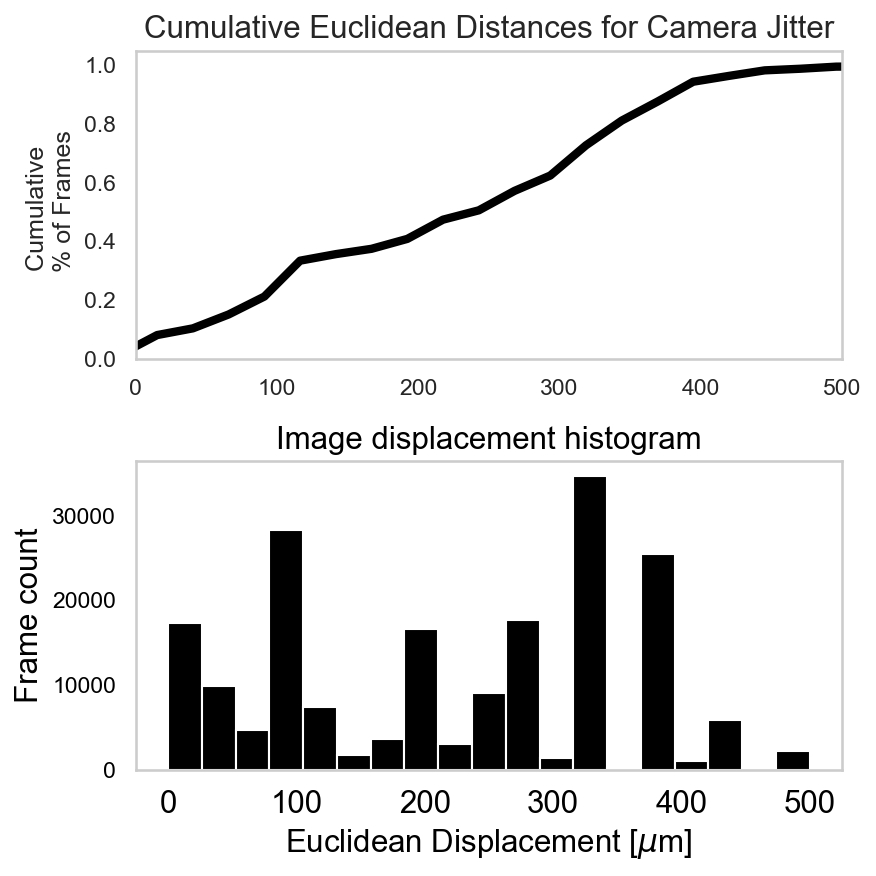

In [13]:
def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs


# This cell produces the jitter magnitude reports before correction:
# define jitter dicts
jitter_dict_l = block.le_jitter_dict
jitter_dict_r = block.re_jitter_dict

# compute euclidean jitter magnitude
xl = np.array(jitter_dict_l['x_displacement'])
yl = np.array(jitter_dict_l['y_displacement'])
l_distances = np.sqrt(xl**2+yl**2)*block.L_pix_size*1000


# compute euclidean jitter magnitude
xr = np.array(jitter_dict_r['x_displacement'])
yr = np.array(jitter_dict_r['y_displacement'])
r_distances = np.sqrt(xr**2+yr**2)*block.R_pix_size*1000

distances = np.concatenate([l_distances, r_distances])

_,_ = create_distance_plot(distances=distances)

Now, I want to collect frames where jitter was too much to correct

In [14]:
# first, verify the parameterization of the jitter removal function:
block.verify_large_jitter_removal_parameters('left', max_distance=8.5, diff_threshold=2, gap_to_bridge=24)


the diff based jitter frame exclusion gives: (34,)
the threshold based jitter frame exclusion gives: (1736,)


TypeError: only integer scalar arrays can be converted to a scalar index

In [13]:
# define the functions
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices


In [14]:

df_inds_to_remove_l, vid_inds_l = find_jittery_frames(block,'left',max_distance=8.5, diff_threshold=2, gap_to_bridge=24)
df_inds_to_remove_r, vid_inds_r = find_jittery_frames(block,'right',max_distance=8.5, diff_threshold=2, gap_to_bridge=24)

# These are verification plots for the jitter outlier removal functions:
# to verify, I want a bokeh explorable:
rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
ldf = pd.DataFrame.from_dict(block.le_jitter_dict)

the diff based jitter frame exclusion gives: (24,)
the threshold based jitter frame exclusion gives: (6,)
the diff based jitter frame exclusion gives: (26,)
the threshold based jitter frame exclusion gives: (9,)


In [15]:
bokeh_plotter([rdf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_r)

In [16]:
bokeh_plotter([ldf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_l)

### The next step finally removes the irrelevant frames

In [17]:
block.remove_eye_datapoints_based_on_video_frames('right', indices_to_nan=vid_inds_r)
block.remove_eye_datapoints_based_on_video_frames('left', indices_to_nan=vid_inds_l)

removed 75 from the right eye dataframe
removed 61 from the left eye dataframe


And now I expect the jitter report to be changed:

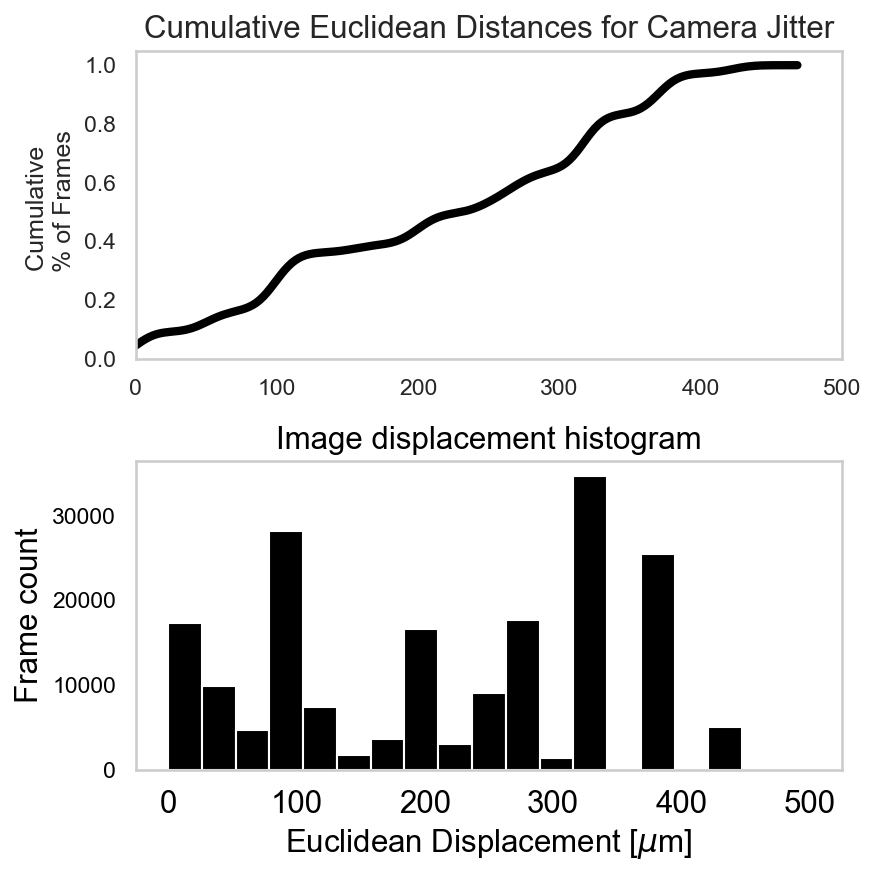

In [23]:
jitter_dict_l = block.le_jitter_dict
jitter_dict_r = block.re_jitter_dict
rdf = pd.DataFrame.from_dict(jitter_dict_r)
ldf = pd.DataFrame.from_dict(jitter_dict_l)
ldf.iloc[vid_inds_l, :] = np.nan
rdf.iloc[vid_inds_r, :] = np.nan
r_distances = rdf['top_correlation_dist']*block.R_pix_size*1000
l_distances = ldf['top_correlation_dist']*block.L_pix_size*1000

all_distances = np.concatenate([l_distances, r_distances])
_,_ = create_distance_plot(distances=all_distances,top_dist_to_show=500)

# I want to understand how to translate my data such that the X and Y axes are reliable and not determined by the camera tilt
This will be achieved by the following solution:
1. get a line that cuts the image along the tearducts of the animal when the pupil is as close to a circle as possible
2. translate phi, x-center and y-center together with the line such that the line is horizontal

In [18]:
block.rotate_data_according_to_frame_ref('left')

Please select two points on the frame.
left rotation matrix: 
 [[   0.88521195   -0.46518791  148.37727417]
 [   0.46518791    0.88521195 -121.31100174]] 
 left rotation angle: 
 -27.722384245207508
left data rotated


In [19]:
block.rotate_data_according_to_frame_ref('right')

Please select two points on the frame.
right rotation matrix: 
 [[  0.75200129   0.65916163 -78.8392052 ]
 [ -0.65916163   0.75200129 270.45141045]] 
 right rotation angle: 
 41.23596513509429
right data rotated


In [20]:
block.create_eye_data()

Index(['Arena_TTL', 'R_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height'],
      dtype='object')
   OE_timestamp  eye_frame   ms_axis    center_x  center_y       phi  \
0      565951.0        NaN  28297.55         NaN       NaN       NaN   
1      566291.0        NaN  28314.55         NaN       NaN       NaN   
2      566631.0        NaN  28331.55         NaN       NaN       NaN   
3      566970.0        NaN  28348.50         NaN       NaN       NaN   
4      567310.0        2.0  28365.50  389.878798  186.7862  0.064448   

       width     height  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4  25.688217  41.897356  
Index(['Arena_TTL', 'L_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height'],
      dtype='object')
   OE_timestamp  eye_frame   ms_axis    center_x    center_y       phi  \
0      565951.0        1.0  28297.55 

Now verify that you've got it correctly rotated

In [21]:
block.right_eye_data['phi'] = block.right_eye_data['phi'] + 90

In [22]:
block.left_eye_data['phi'] = block.left_eye_data['phi'] + 90

In [23]:
# right eye inspection after rotation
path_to_video = [x for x in pathlib.Path(block.re_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
print(path_to_video)
play_video_with_ellipses_rotation(block=block,eye='right', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.right_rotation_matrix)

Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\eye_videos\RE\230427_pv62_trial4_640x480_60hz_experiment_1_recording_0\230427_pv62_trial4DLC_resnet50_pogona_eye_trackingMay25shuffle1_1030000_labeled.mp4


In [24]:
# left eye inspection
path_to_video = [x for x in pathlib.Path(block.le_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
play_video_with_ellipses_rotation(block=block,eye='left', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.left_rotation_matrix)

# after verification, I want to have a function that exports the right/left eye data dfs and the rotation matrices + angles to file 

In [25]:
def export_eye_data_2d_w_rotation_matrix(block):
    """
    This function saves the eye dataframes to two csv files
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
        
    block.right_eye_data.to_csv(block.analysis_path / 'right_eye_data.csv')
    block.left_eye_data.to_csv(block.analysis_path / 'left_eye_data.csv')
    rotation_dict = {'left_rotation_matrix': block.left_rotation_matrix,
                'left_rotation_angle':  block.left_rotation_angle,
                'right_rotation_matrix':block.right_rotation_matrix,
                'right_rotation_angle': block.right_rotation_angle}
    with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'wb') as file:
        pickle.dump(rotation_dict, file)
        

export_eye_data_2d_w_rotation_matrix(block)


In [35]:
def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0)
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0)
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    


In [25]:
# this is the second iteration of the rotation verification function:
def rotate_frame_to_horizontal_with_interpolation(path_to_video_file, frame_number, ellipse_df, xflip=True, output_path= None):
    """
    Rotate the specified frame from a video file to horizontal orientation with interpolation.

    Parameters:
    - path_to_video_file (str): Path to the video file.
    - frame_number (int): Frame number to be processed.
    - ellipse_df (pd.DataFrame): DataFrame containing ellipse parameters for each frame.
    - xflip (bool, optional): Flag to horizontally flip the frame (default is True).
    - output_path (str, optional): Path to save the output video file (default is None).

    Returns:
    - rotation_matrix (np.ndarray): The rotation matrix used for the transformation.
    - angle (float): The rotation angle applied to the frame.
    """
    # Read the video file
    cap = cv2.VideoCapture(path_to_video_file)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return None

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if not ret:
        print(f"Error: Unable to read frame {frame_number}.")
        cap.release()
        return None

    # horizontally flip frame if applicable:
    if xflip:
        frame = cv2.flip(frame, 1)

    # get the original ellipse from the block dataframe
    if 'R_eye_frame' in ellipse_df.columns:
        current_frame_data = ellipse_df.iloc[ellipse_df.query('R_eye_frame == @frame_number').index[0]]
    elif 'L_eye_frame' in ellipse_df.columns:
        current_frame_data = ellipse_df.iloc[ellipse_df.query('L_eye_frame == @frame_number').index[0]]

    # Extract ellipse parameters
    try:
        center_x = int(current_frame_data['center_x'])
        center_y = int(current_frame_data['center_y'])
        width = int(current_frame_data['width'])
        height = int(current_frame_data['height'])
        phi = float(current_frame_data['phi'])

        # Draw the ellipse on the frame
        cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
    except ValueError:
        print('could not paint ellipse, missing values')

    # Display the frame
    cv2.imshow("Original Frame", frame)

    # Prompt user to select two points
    print("Please select two points on the frame.")

    # Callback function for mouse events
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))

    # Set up the mouse callback
    cv2.setMouseCallback("Original Frame", mouse_callback)

    # Wait for the user to select two points
    points = []
    while len(points) < 2:
        cv2.waitKey(1)

    # Draw a line between the selected points
    cv2.line(frame, points[0], points[1], (0, 255, 0), 2)
    cv2.imshow("Line Drawn Frame", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Calculate the rotation angle
    angle = np.arctan2(points[1][1] - points[0][1], points[1][0] - points[0][0]) * 180 / np.pi

    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((frame.shape[1] // 2, frame.shape[0] // 2), angle, 1)
    #rotation_matrix[:,2] = 0
    
    # Generate and display video with 50 steps between original and rotated frames
    for step in range(51):
        alpha = step / 50.0
        current_rotation_matrix = cv2.getRotationMatrix2D(
            (frame.shape[1] // 2, frame.shape[0] // 2),
            angle * alpha,
            1
        )
     #   current_rotation_matrix[:,2] = 0
        rotated_frame = cv2.warpAffine(frame, current_rotation_matrix, (frame.shape[1], frame.shape[0]))

        cv2.imshow("Interpolated Rotated Frame", rotated_frame)
        
        cv2.waitKey(100)  # Adjust the wait time to control the playback speed

    # Release resources

    cap.release()
    cv2.destroyAllWindows()

    return rotation_matrix, angle

"""
Example usage
path_to_video = block.le_videos[0]
frame_number = frame_number_to_show
output_path = block.analysis_path / 'frame_rotation.avi'
transformation_matrix, angle = rotate_frame_to_horizontal_with_interpolation(path_to_video, frame_number, block.le_df, output_path=None)
print("Transformation Matrix:")
print(transformation_matrix)
"""


'\nExample usage\npath_to_video = block.le_videos[0]\nframe_number = frame_number_to_show\noutput_path = block.analysis_path / \'frame_rotation.avi\'\ntransformation_matrix, angle = rotate_frame_to_horizontal_with_interpolation(path_to_video, frame_number, block.le_df, output_path=None)\nprint("Transformation Matrix:")\nprint(transformation_matrix)\n'

In [26]:
def apply_rotation_around_center_to_df(eye_df, transformation_matrix, rotation_angle):
    """This is a static method for applying the transformation matrix to eye dataframes within a block class object"""
    original_centers = eye_df[['center_x_corrected', 'center_y_corrected']].values
    original_phi = eye_df['phi'].values
    M = transformation_matrix
    # apply the rotation to xy
    rotated_centers = np.dot(original_centers, M[:, :2].T) + M[:, 2]
    # apply rotation to phi
    rotated_phi = np.rad2deg(original_phi) + rotation_angle
    
    eye_df['center_x_rotated'] = rotated_centers[:,0]
    eye_df['center_y_rotated'] = rotated_centers[:,1]
    eye_df['phi_rotated'] = rotated_phi
    
    return eye_df

In [27]:
# Initialize for left eye video
# get the frames where the pupil is closest to round:
s = block.le_df.width / block.le_df.height
closest_ind = np.argmin(np.abs(s - 1)) # find the index of the value closest to 1
eye = 'L_eye_frame'
frame_number_to_show = block.le_df[eye].iloc[closest_ind]
path_to_video = block.le_videos[0]
frame_number = frame_number_to_show
ellipse_df = block.le_df

left_rotation_matrix, left_angle = rotate_frame_to_horizontal_with_interpolation(path_to_video_file=path_to_video,
                                                                                 frame_number=frame_number,
                                                                                 ellipse_df=ellipse_df,
                                                                                 xflip=True)
print("Left rotation matrix:")
print(left_rotation_matrix)
print("Left angle")
print(left_angle)
block.left_rotation_matrix = left_rotation_matrix
block.left_rotation_angle = left_angle

Please select two points on the frame.
Left rotation matrix:
[[   0.88334902   -0.46871581  149.82010703]
 [   0.46871581    0.88334902 -121.99282317]]
Left angle
-27.95096902789018


In [28]:
# initialize for right eye video
# get the frames where the pupil is closest to round:
s = block.re_df.width / block.re_df.height
closest_ind = np.argmin(np.abs(s - 1)) # find the index of the value closest to 1
frame_number_to_show = block.re_df.R_eye_frame.iloc[closest_ind]
path_to_video = block.re_videos[0]
frame_number = frame_number_to_show
ellipse_df = block.re_df

right_rotation_matrix, right_angle = rotate_frame_to_horizontal_with_interpolation(path_to_video_file=path_to_video,
                                                                                   frame_number=frame_number,
                                                                                   ellipse_df=ellipse_df,
                                                                                   xflip=True)
print("Right rotation matrix:")
print(right_rotation_matrix)
print("Right angle")
print(right_angle)
block.right_rotation_matrix = right_rotation_matrix
block.right_rotation_angle = right_angle

Please select two points on the frame.
Right rotation matrix:
[[  0.87591906   0.48245809 -76.08403925]
 [ -0.48245809   0.87591906 184.16601528]]
Right angle
28.84606715089911


In [115]:
# apply the transformation and rotation gathered in the previous stage
block.re_df = apply_rotation_around_center_to_df(eye_df = block.re_df.copy(),
                                           transformation_matrix = right_rotation_matrix,
                                           rotation_angle = right_angle)
block.le_df = apply_rotation_around_center_to_df(eye_df = block.le_df.copy(),
                                           transformation_matrix = left_rotation_matrix,
                                           rotation_angle= left_angle)



In [116]:
# create the eye_data dfs to finalize the translation and sort out some mess
block.right_eye_data = block.re_df.copy()
block.right_eye_data = block.right_eye_data[['Arena_TTL', 'R_eye_frame', 'ms_axis', 
                                             'center_x_rotated', 'center_y_rotated',
                                             'phi_rotated','width', 'height']]
block.left_eye_data = block.le_df.copy()
block.left_eye_data = block.left_eye_data[['Arena_TTL', 'L_eye_frame', 'ms_axis', 
                                             'center_x_rotated', 'center_y_rotated',
                                             'phi_rotated','width', 'height']]


In [117]:
# change dataframe column names to comply with earlier code
translation_dict = {'center_x_rotated':'center_x',
                    'center_y_rotated':'center_y',
                    'phi_rotated':'phi',
                    'L_eye_frame':'eye_frame',
                    'R_eye_frame': 'eye_frame',
                    'Arena_TTL':'OE_timestamp'}
for df in [block.right_eye_data, block.left_eye_data]:
    print(df.columns)
    df.rename(columns=translation_dict, inplace=True)
    print(df.head())


Index(['Arena_TTL', 'R_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height'],
      dtype='object')
   OE_timestamp  eye_frame   ms_axis  center_x  center_y  phi  width  height
0      489228.0        NaN  24461.40       NaN       NaN  NaN    NaN     NaN
1      489568.0        NaN  24478.40       NaN       NaN  NaN    NaN     NaN
2      489907.0        NaN  24495.35       NaN       NaN  NaN    NaN     NaN
3      490247.0        NaN  24512.35       NaN       NaN  NaN    NaN     NaN
4      490587.0        NaN  24529.35       NaN       NaN  NaN    NaN     NaN
Index(['Arena_TTL', 'L_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height'],
      dtype='object')
   OE_timestamp  eye_frame   ms_axis    center_x    center_y        phi  \
0      489228.0        8.0  24461.40  426.281506  196.920111 -13.032192   
1      489568.0        9.0  24478.40  426.293619  196.944699 -12.962090   
2      489907

# Now I should verify this worked...

# over here, I can load the eye dataframes if I already exported them

In [18]:
block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0)
block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0)

In [20]:
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values
                    }
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        # calculate intermittent angles:
        #step_angles = np.arctan2(saccade_samples['center_y'].diff(), saccade_samples['center_x'].diff())
        #correlation_score = np.corrcoef(step_angles, overall_angle)[0, 1]
        #correlations.append(correlation_score)
        angles.append(overall_angle)  # Convert radians to degrees and ensure result is in [0, 360)
        distances.append(distance_traveled)
    
    saccade_events_df['magnitude'] = distances 
    saccade_events_df['angle'] = np.rad2deg(angles) %360
    
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df

In [21]:
block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data, speed_threshold=2, bokeh_verify_threshold=True)
block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data, speed_threshold=2, bokeh_verify_threshold=False)

963it [00:01, 757.45it/s]
<ipython-input-20-0ed2046103a3>:80: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
1002it [00:01, 763.79it/s]
<ipython-input-20-0ed2046103a3>:80: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360


# END of working pipeline

In [56]:
start_ms = block.left_eye_data[block.left_eye_data['OE_timestamp'] == block.l_saccade_df.saccade_start_timestamp[0]].ms_axis.values[0]
end_ms = block.left_eye_data[block.left_eye_data['OE_timestamp'] == block.l_saccade_df.saccade_end_timestamp[0]].ms_axis.values[0]
print(start_ms)
print(end_ms)
show_synced_eye_videos(block,start_ms=start_ms, end_ms = end_ms+10000, xflip=True, rotate_frames=True)

31473.6
31524.5


In [34]:
block.l_saccade_df

,saccade_start_ind,saccade_start_timestamp,saccade_end_ind,saccade_end_timestamp,length,magnitude,angle,initial_x,initial_y,end_x,end_y
0,187,629472.0,190,630490.0,3,9.932899,191.060017,443.701380,208.074354,434.815437,206.337440
1,195,632189.0,197,632869.0,2,5.246787,178.357383,434.059964,206.407190,430.055567,206.522024
2,431,712366.0,437,714406.0,6,57.520999,192.272786,432.873161,206.079406,377.421321,194.016537
3,437,714406.0,439,715085.0,2,5.041011,295.612636,377.421321,194.016537,379.290380,190.117718
4,440,715425.0,442,716104.0,2,5.511173,24.877704,380.896509,190.225431,384.397426,191.848847
...,...,...,...,...,...,...,...,...,...,...,...
943,99020,34199800.0,99023,34200818.0,3,9.938166,188.530117,384.550090,187.577661,376.837254,186.420825
944,99025,34201498.0,99029,34202856.0,4,12.079636,12.436074,376.539197,186.155427,387.969751,188.676143
945,99029,34202856.0,99031,34203535.0,2,5.350909,26.410003,387.969751,188.676143,392.743904,191.047092
946,99055,34211686.0,99059,34213044.0,4,20.271445,12.094669,401.080781,193.963496,418.462983,197.688225


In [51]:
# I want to collect saccade events from the new dataframe:
# first stage is to understand pupil speeds:
# Step 1: Calculate speed in each axis
df = block.left_eye_data.copy()
df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

# Step 2: Calculate magnitude of the velocity vector (R vector speed)
df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5


In [52]:
# now detect saccade events and chunk them:
speed_threshold = 2
# Create a column for saccade detection
df['is_saccade'] = df['speed_r'] > speed_threshold

# create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
saccade_on_inds = np.where(saccade_on_off == 1)[0]
saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
saccade_off_inds = np.where(saccade_on_off == -1)[0]
saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]

saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                'saccade_start_timestamp': saccade_on_timestamps.values,
                'saccade_end_ind':      saccade_off_inds,
                'saccade_end_timestamp':saccade_off_timestamps.values
                }
saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
# Drop columns used for intermediate steps
# df = df.drop(['is_saccade'], axis=1)

distances = []
angles = []
correlations = []


for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
    saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                             (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
    distance_traveled = saccade_samples['speed_r'].sum()
    # Calculate angle from initial position to endpoint
    initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
    endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
    overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                       endpoint['center_x'] - initial_position['center_x'])
    
    # calculate intermittent angles:
    #step_angles = np.arctan2(saccade_samples['center_y'].diff(), saccade_samples['center_x'].diff())
    #correlation_score = np.corrcoef(step_angles, overall_angle)[0, 1]
    #correlations.append(correlation_score)
    angles.append(overall_angle)  # Convert radians to degrees and ensure result is in [0, 360)
    distances.append(distance_traveled)


saccade_events_df['magnitude'] = distances 
saccade_events_df['angle'] = np.rad2deg(angles) %360
# now get xy coordinates for start and end timestamps:
start_ts = saccade_events_df['saccade_start_timestamp'].values
end_ts = saccade_events_df['saccade_end_timestamp'].values
saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
start_x_coord = saccade_start_df['center_x']
start_y_coord = saccade_start_df['center_y']
end_x_coord = saccade_end_df['center_x']
end_y_coord = saccade_end_df['center_y']
saccade_events_df['initial_x'] = start_x_coord.values
saccade_events_df['initial_y'] = start_y_coord.values
saccade_events_df['end_x'] = end_x_coord.values
saccade_events_df['end_y'] = end_y_coord.values
saccade_events_df
#saccade_events_df['correlation'] = correlations

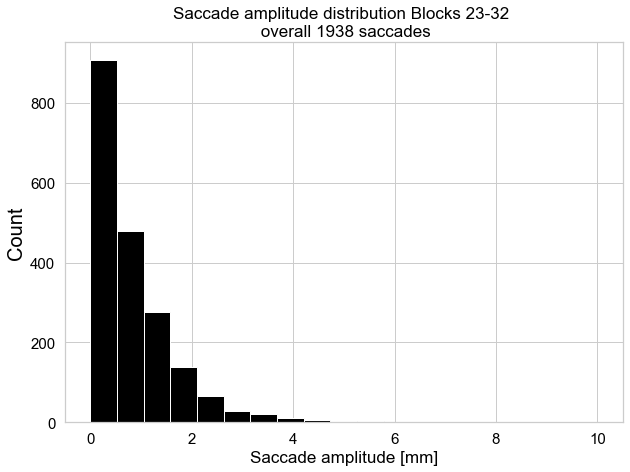

In [35]:
# make a histogram plot for all saccade magnitudes (L/R):
all_magnitudes_mm = np.hstack([block.l_saccade_df['magnitude'].values * block.L_pix_size, block.r_saccade_df['magnitude'].values * block.R_pix_size])
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the histogram
ax.hist(all_magnitudes_mm,bins=np.linspace(0,10,20),log=True, color='black')

# Set title and labels
title = f'Saccade amplitude distribution Blocks 23-32 \n overall {len(all_magnitudes_mm)} saccades'
ax.set_title(title, fontsize=17)
ax.set_xlabel('Saccade amplitude [mm]', fontsize=17)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=20)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=15)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')

plt.show()

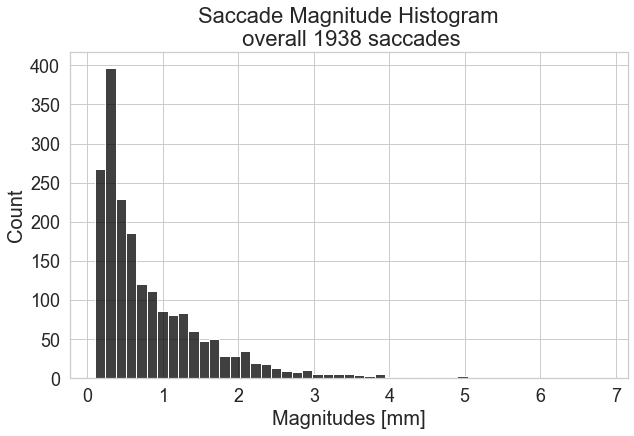

In [36]:
# Create a Seaborn histogram plot
sns.set(style="whitegrid")  # Remove the background grid
plt.figure(figsize=(10, 6))  # Enlarge the plot

# Set custom color for the bars
ax = sns.histplot(all_magnitudes_mm, color='black')

# Customize text size
ax.set_title(f'Saccade Magnitude Histogram\n overall {len(all_magnitudes_mm)} saccades', fontsize=22)
ax.set_xlabel('Magnitudes [mm]', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='both', labelsize=18)


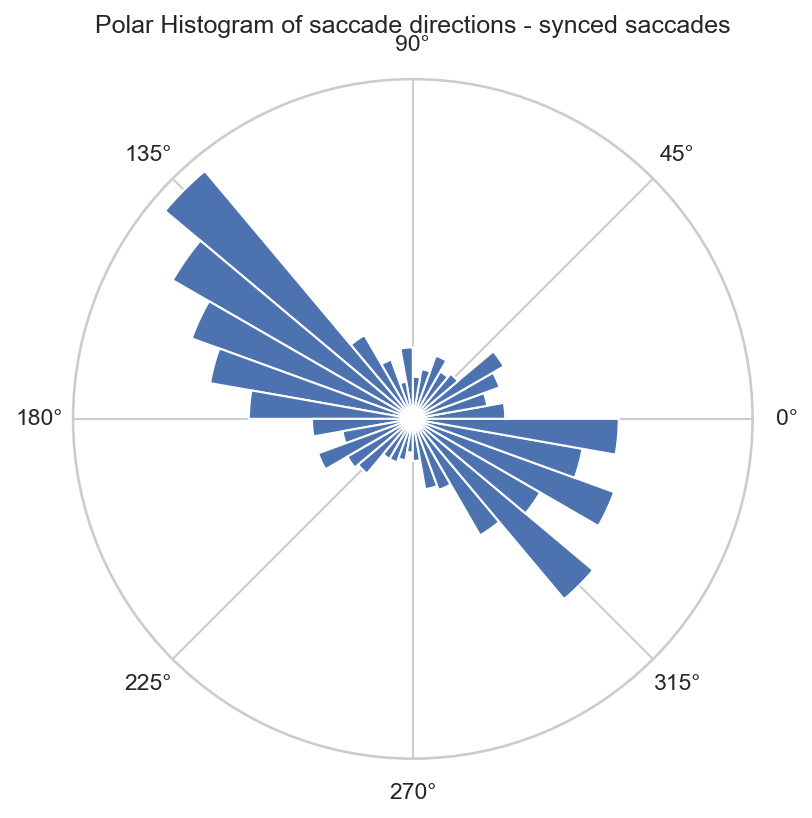

In [39]:
# saccade_angles = np.hstack([block.l_saccade_df['angle'].values, 
#                             block.r_saccade_df['angle'].values])
saccade_angles = block.r_saccade_df['angle'].values
num_bins = 36
hist, bin_edges = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360/num_bins), align='center')

#ax.set_theta_direction(-1)
#ax.set_theta_offset(np.radians(90))
ax.grid(True)
#ax.set_rlabel_position(0)
ax.set_yticks([])
plt.title("Polar Histogram of saccade directions - synced saccades")

plt.show()

In [74]:
saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
saccade_on_inds = np.where(saccade_on_off == 1)[0]
saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
saccade_off_inds = np.where(saccade_on_off == -1)[0]
saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
saccade_dict = {
    'saccade_on_timestamps':    saccade_on_timestamps.values,
    'saccade_off_timestamps':   saccade_off_timestamps.values
}
saccade_events = pd.DataFrame.from_dict(saccade_dict)
saccade_events

,saccade_on_timestamps,saccade_off_timestamps
0,543242.0,543921.0
1,586047.0,586727.0
2,597599.0,598279.0
3,673697.0,674037.0
4,762709.0,763049.0
...,...,...
480,32141307.0,32142666.0
481,32240480.0,32241159.0
482,32252707.0,32253386.0
483,32259839.0,32260518.0


In [65]:
saccade_events_df.columns

Index(['saccade_start_ind', 'saccade_start_timestamp', 'saccade_end_ind',
       'saccade_end_timestamp', 'length', 'initial_x', 'initial_y', 'end_x',
       'end_y'],
      dtype='object')

In [56]:
bokeh_plotter(data_list=[df.speed_r],label_list=['Speed'], peaks=saccade_off_inds)

In [54]:


# Create a Bokeh figure
p = bokeh.figure(title='Eye Movement Speed with Saccade Events', x_axis_label='OE_Timestamp', y_axis_label='Speed (R)',
           width=1800, height=700)

# Plot speed graph
p.line(x='OE_timestamp', y='speed_r', source=df, line_width=2, line_color='blue', legend_label='Speed (R)')

# Plot saccade start points
p.circle(x=saccade_events['saccade_start_timestamp'], y=[0]*len(saccade_events),
         size=8, color='red', legend_label='Saccade Start')

# Plot saccade end points
p.circle(x=saccade_events['saccade_end_timestamp'], y=[0]*len(saccade_events),
         size=8, color='green', legend_label='Saccade End')

# Show the plot
bokeh.show(p)



In [48]:
len(saccade_events)

971

In [8]:
import pandas as pd

def detect_saccades(df, speed_threshold):
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # Identify consecutive chunks where 'is_saccade' is True
    df['saccade_chunk'] = (df['is_saccade'] != df['is_saccade'].shift()).cumsum()

    # Group by 'saccade_chunk' and calculate start and end timestamps
    saccade_events = (df.groupby('saccade_chunk')
                      .agg(saccade_start_timestamp=('OE_timestamp', 'first'),
                           saccade_end_timestamp=('OE_timestamp', 'last'))
                      .reset_index(drop=True))

    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade', 'saccade_chunk'], axis=1)

    return saccade_events




,Arena_TTL,index,Unnamed: 0.1,R_eye_frame,L_values,R_values,center_x,center_y,width,height,phi,ellipse_size,ms_axis,center_x_corrected,center_y_corrected
0,605092.0,0,0,1.0,NaN,0.885172,329.658646,250.250975,47.719488,33.468928,0.261552,5017.500800,30254.60,329.658646,250.250975
1,605431.0,1,1,2.0,NaN,0.887300,329.553549,250.337861,47.743960,33.410857,0.261714,5011.363778,30271.55,329.553549,250.337861
2,605771.0,2,2,3.0,NaN,0.890668,329.549745,250.345209,47.746411,33.421520,0.261817,5013.220329,30288.55,329.549745,250.345209
3,606111.0,3,3,4.0,NaN,0.892202,329.517116,250.357417,47.683452,33.422243,0.260236,5006.718323,30305.55,329.517116,250.357417
4,606451.0,4,4,5.0,-2.813021,0.893261,329.354194,250.382232,47.632214,33.373532,0.270074,4994.049142,30322.55,329.354194,250.382232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91948,31841220.0,91948,91948,93880.0,-1.851355,1.670915,406.511275,259.860345,27.489900,44.459345,-0.757032,3839.601034,1592061.00,410.511275,259.860345
91949,31841560.0,91949,91949,93881.0,-1.855220,1.670836,406.518275,259.861253,27.536835,44.459374,-0.758336,3846.159073,1592078.00,410.518275,259.861253
91950,31841900.0,91950,91950,93882.0,-1.851100,1.670840,406.541420,259.892993,27.577937,44.409008,-0.758430,3847.536187,1592095.00,410.541420,259.892993
91951,31842239.0,91951,91951,93883.0,-1.852275,1.670417,406.581305,259.871842,27.539825,44.425089,-0.757278,3843.610443,1592111.95,410.581305,259.871842


In [42]:
df

,OE_timestamp,eye_frame,ms_axis,center_x,center_y,phi,width,height,speed_x,speed_y,speed_r
0,489228.0,8.0,24461.40,426.667884,197.885896,76.448107,45.652720,33.360344,NaN,NaN,NaN
1,489568.0,9.0,24478.40,426.679774,197.910592,76.518209,45.650638,33.354662,0.011890,0.024696,0.027409
2,489907.0,11.0,24495.35,426.638287,197.901864,76.629702,45.639808,33.348853,-0.041487,-0.008728,0.042395
3,490247.0,11.0,24512.35,426.638287,197.901864,76.629702,45.639808,33.348853,0.000000,0.000000,0.000000
4,490587.0,12.0,24529.35,426.548423,197.896510,77.068176,45.489204,33.231075,-0.089864,-0.005354,0.090024
...,...,...,...,...,...,...,...,...,...,...,...
94071,32445276.0,NaN,1622263.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94072,32445615.0,NaN,1622280.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94073,32445955.0,NaN,1622297.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94074,32446294.0,NaN,1622314.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# for each eye, get the median displacement vector -> create a synced version of the correction
# according to previous sync -> perform column based addition / subtraction to correct the jitter
# -> measure std decline to validate correction
# right eye:
rx_median_series = pd.Series(signal.medfilt(block.re_jitter_dict['x_displacement'], kernel_size=13),
                             name='x_correction')
ry_median_series = pd.Series(signal.medfilt(block.re_jitter_dict['y_displacement'], kernel_size=13),
                             name='y_correction')
r_correction_df = pd.concat([ry_median_series, rx_median_series], axis=1)
# r_corrected = block.re_df[['Arena_TTL', 'R_eye_frame', 'center_y', 'center_x']].set_index('R_eye_frame').merge(
#     r_correction_df,
#     how='left',
#     left_index=True,
#     right_index=True)
#r_corrected['center_y_corrected'] = r_corrected['center_y'] + r_corrected['y_correction']
#r_corrected['center_x_corrected'] = r_corrected['center_x'] + r_corrected['x_correction']




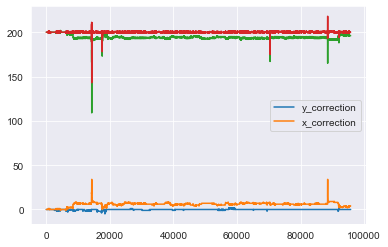

In [57]:
ax = r_correction_df.plot(kind='line')
ax.plot(block.re_jitter_dict['top_correlation_x'], label='x_coord')
ax.plot(block.re_jitter_dict['top_correlation_x']+r_correction_df['x_correction'], label='x_corected')


In [10]:
# L eye plot
x_before = block.re_df['center_x']
x_after = block.re_df['center_x_corrected']
y_before = block.re_df['center_y']
y_after = block.re_df['center_y_corrected']

bokeh_plotter([x_before, x_after, y_before, y_after], ["x_before", "x_after", "y_before", "y_after"])

In [14]:
type(block.led_blink_frames_l)


numpy.ndarray

In [66]:
# get the R vector for a median absolute deviation calc

jitter_dict = block.re_jitter_dict
# Compute euclidean jitter magnitude
x = np.array(jitter_dict['x_displacement'])
y = np.array(jitter_dict['y_displacement'])
r = np.sqrt(x**2 + y**2)
corr_score = jitter_dict['top_correlation_values']
mean_value = np.mean(r)
mad = np.mean(np.abs(r - mean_value))
extreme_inds = np.where(r > 5 * mad)[0]
filt_r = scipy.signal.medfilt(r, kernel_size=121)
threshold = 3
peaks = np.where(np.abs(np.diff(filt_r)) > threshold)[0]
bokeh_plotter([ r, filt_r, np.abs(np.diff(filt_r))], ['R', 'filtered_R', 'derivative'],
              plot_name='mean absolute deviation', x_axis='frame', y_axis='euclidean displacement', peaks=peaks)
print(len(extreme_inds))

120


In [55]:
threshold = 3
peaks = np.where(np.abs(np.diff(filt_r)) > threshold)[0]
peaks

array([ 3606,  3607,  3608,  3609,  3610,  3734,  4578,  4887, 10638,
       17224, 17228, 20912, 78914, 79687, 88782, 88783, 93412],
      dtype=int64)

In [137]:
# This is the first iteration of the manual frame rotation annotator:

# OLD VERSION OF THE FUNCTION
def rotate_frame_to_horizontal_old(path_to_video_file, frame_number, ellipse_df, xflip=True):
    # Read the video file
    cap = cv2.VideoCapture(path_to_video_file)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return None

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if not ret:
        print(f"Error: Unable to read frame {frame_number}.")
        cap.release()
        return None
    
    # horizontally flip frame if applicable:
    if xflip:
        frame = cv2.flip(frame, 1)
    # get the original ellipse from the block dataframe
    if 'R_eye_frame' in ellipse_df.columns:
        current_frame_data = ellipse_df.iloc[ellipse_df.query('R_eye_frame == @frame_number').index[0]]
    elif 'L_eye_frame' in ellipse_df.columns:
        current_frame_data = ellipse_df.iloc[ellipse_df.query('L_eye_frame == @frame_number').index[0]]
        
    # Extract ellipse parameters
    try:
        center_x = int(current_frame_data['center_x'])
        center_y = int(current_frame_data['center_y'])
        width = int(current_frame_data['width'])
        height = int(current_frame_data['height'])
        phi = float(current_frame_data['phi'])

        # Draw the ellipse on the frame
        cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
    except ValueError:
        print('could not paint ellipse, missing values')
    
    
    # Display the frame
    cv2.imshow("Original Frame", frame)

    # Prompt user to select two points
    print("Please select two points on the frame.")
    
    # Callback function for mouse events
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))

    # Set up the mouse callback
    cv2.setMouseCallback("Original Frame", mouse_callback)

    # Wait for the user to select two points
    points = []
    while len(points) < 2:
        cv2.waitKey(1)

    # Draw a line between the selected points
    cv2.line(frame, points[0], points[1], (0, 255, 0), 2)
    cv2.imshow("Line Drawn Frame", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Calculate the rotation angle
    angle = np.arctan2(points[1][1] - points[0][1], points[1][0] - points[0][0]) * 180 / np.pi
        
    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((frame.shape[1] // 2, frame.shape[0] // 2), angle, 1)
    
    #rotation_matrix[:, 2] = 0  # Set translation components to zero
    
    # Rotate the frame
    rotated_frame = cv2.warpAffine(frame, rotation_matrix, (frame.shape[1], frame.shape[0]))

    # Display the rotated frame
    cv2.imshow("Rotated Frame", rotated_frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Release the video capture object
    cap.release()

    return rotation_matrix




Please select two points on the frame.
Transformation Matrix:
[[-8.56851544e-01  5.15563217e-01  4.70457322e+02]
 [-5.15563217e-01 -8.56851544e-01  6.10624600e+02]]
